In [1]:
import numpy as np
import xarray as xr
from useful_functions import data_compiler
from useful_functions import environmental_select_stack
from useful_functions import create_genesis_grid_labels
from useful_functions import temporal_spatial_smoothing
import os
import tropycal.tracks as tracks
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import cartopy.crs as ccrs
import copy
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.metrics import mean_squared_error
from scipy import stats
import regionmask
import geopandas as gpd

In [2]:
# Read the shapefile
gdf = gpd.read_file("/glade/work/acheung/Initial_RF_Datasets/shape_files_regions/World_Seas_IHO_v3.shp")

In [3]:
Latitude=np.arange(0,60,2)
Longitude=np.arange(260,360,2)
# Create masks based on regions
NAO_polygon = gdf.loc[(gdf['NAME'] == 'North Atlantic Ocean') | (gdf['NAME'] == 'Gulf of Mexico') | (gdf['NAME'] == 'Caribbean Sea')]
lon_adj = np.where(Longitude > 180, Longitude - 360,Longitude)
NAOmask = regionmask.mask_geopandas(NAO_polygon, Longitude, Latitude,lon_name='Longitude', lat_name='Latitude',wrap_lon=True)

In [4]:
# Compile Environmental Data
vars_list = os.listdir("/glade/work/acheung/TC_Genesis") # Determine Variables
vars_list.remove('.DS_Store')
vars_list.remove('CRH_ERA5')
all_vars_list = []
for vars_list_now in vars_list:
    Varcompiled, YearList,lons,lats,arr = data_compiler(vars_list_now)
    all_vars_list.append(Varcompiled)

arr = xr.DataArray(all_vars_list,coords=[("Variable",vars_list),("Year",range(1950,2021)),("Latitude",lats),("Longitude",lons),("Month",range(1,13))])

# # Time ranges for EVERYTHING desired 
# NOTE: Keep in mind that when switching these values... 
# you may need to adjust create_genesis_grid_labels in useful_functions and also rerun/uncomment the code below!

# Set time parameters
month_range = np.arange(1,13,1)
test_years = np.arange(2005,2021,1)
train_years = np.arange(1950,2005,1)
train_years = np.setdiff1d(train_years, np.arange(1971,1979,1))

# Grab environmental data from functions for the set time parameters
train_stacked,train_NaNlocs = environmental_select_stack(month_range,train_years,Latitude,Longitude,arr)
test_stacked,test_NaNlocs = environmental_select_stack(month_range,test_years,Latitude,Longitude,arr)

# ----------------------------------------------------------------Add latitude and logitude input arrays for training dataset--------------------------------------

xv, yv = np.meshgrid(train_stacked.unstack().coords['Longitude'].values,train_stacked.unstack().coords['Latitude'].values)
tiled_lon = np.tile(xv,(train_stacked.unstack().shape[4],train_stacked.unstack().shape[1],1,1)).transpose(1,2,3,0)
tiled_lat = np.tile(yv,(train_stacked.unstack().shape[4],train_stacked.unstack().shape[1],1,1)).transpose(1,2,3,0)

lon_4d = xr.DataArray(tiled_lon,coords=train_stacked.unstack()[0].coords)
lon_4d['Variable'] = 'Longitude Input'

lat_4d = xr.DataArray(tiled_lat,coords=train_stacked.unstack()[0].coords)
lat_4d['Variable'] = 'Latitude Input'

train_stacked_modify = xr.concat([train_stacked.unstack(),lon_4d],dim='Variable')
train_stacked = xr.concat([train_stacked_modify.unstack(),lat_4d],dim='Variable').stack(z=("Month","Latitude","Longitude","Year"))

# Add latitude and logitude input arrays for testing dataset
xv_test, yv_test = np.meshgrid(test_stacked.unstack().coords['Longitude'].values,test_stacked.unstack().coords['Latitude'].values)
tiled_lon_test = np.tile(xv_test,(test_stacked.unstack().shape[4],test_stacked.unstack().shape[1],1,1)).transpose(1,2,3,0)
tiled_lat_test = np.tile(yv_test,(test_stacked.unstack().shape[4],test_stacked.unstack().shape[1],1,1)).transpose(1,2,3,0)

lon_4d_test = xr.DataArray(tiled_lon_test,coords=test_stacked.unstack()[0].coords)
lon_4d_test['Variable'] = 'Longitude Input'

lat_4d_test = xr.DataArray(tiled_lat_test,coords=test_stacked.unstack()[0].coords)
lat_4d_test['Variable'] = 'Latitude Input'

test_stacked_modify = xr.concat([test_stacked.unstack(),lon_4d_test],dim='Variable')
test_stacked = xr.concat([test_stacked_modify.unstack(),lat_4d_test],dim='Variable').stack(z=("Month","Latitude","Longitude","Year"))

#----------------------------------------------------------------------------------------------------------------------------------------------------------

# Apply land/ocean mask to environmental training information
train_stacked = (train_stacked.unstack()).where(NAOmask.isnull() == False).stack(z=("Month","Latitude","Longitude","Year"))

# Apply land/ocean mask to environmental testing information
test_stacked = (test_stacked.unstack()).where(NAOmask.isnull() == False).stack(z=("Month","Latitude","Longitude","Year")) # This is a mask to restrict to only ocean

# Normalize environmental data for training

# Min/Max Scaling (Normalization)
train_stacked_copy = copy.deepcopy(train_stacked) # For modifying (normalized)
train_stacked_copy_2 = copy.deepcopy(train_stacked) # For referencing 
train_stacked_copy_3 = copy.deepcopy(train_stacked) # For storing anomaly (not normalized)
test_stacked_copy = copy.deepcopy(test_stacked)
test_stacked_copy_2 = copy.deepcopy(test_stacked)
test_stacked_copy_3 = copy.deepcopy(test_stacked)

# ------------------------------------------Important settings-------------------------------------------------------
anomaly = 0 # 1 = Set for anomaly
normalization = 2 # 1 for min/max normalization, 2 for z-score normalization
# ------------------------------------------------------------------------------------------------------------------

for varloops in range(train_stacked_copy.shape[0]): 
    ## Find anomalies and then normalize training Data or not.
    
    if anomaly == 1: # If anomaly desired, this is equal to 1; Base anomalies off training monthly means
    
    # Find Training Data Anomalies
    
        train_monthly_avg = train_stacked_copy_2[varloops].unstack().mean(["Year"]).stack(z=("Month","Latitude","Longitude"))
        # Calculate Anomaly (subtract values from monthly averages)
        train_anomaly = (train_stacked_copy_2[varloops].unstack()-train_monthly_avg.unstack()).stack(z=("Month","Latitude","Longitude","Year"))
       
        # Save anomalies before normalization
        train_stacked_copy_3[varloops,:] = train_anomaly
        
        # Normalize the anomalies and save
        if normalization == 1:
            train_stacked_copy[varloops,:] = (train_anomaly - train_anomaly.min())/(train_anomaly.max()-train_anomaly.min())
        elif normalization == 2:
            train_stacked_copy[varloops,:] = (train_anomaly - train_anomaly.mean())/(train_anomaly.std())
        
    # Find Testing Data Anomalies (NOTE: Based off training monthly means)
    
        # Calculate Anomaly (subtract values from monthly averages)
        test_anomaly = (test_stacked_copy_2[varloops].unstack()-train_monthly_avg.unstack()).stack(z=("Month","Latitude","Longitude","Year"))
        
        # Save anomalies before normalization
        test_stacked_copy_3[varloops,:] = test_anomaly
        
        # Normalize the anomalies
        if normalization == 1:
            test_stacked_copy[varloops,:] = (test_anomaly - train_anomaly.min())/(train_anomaly.max()-train_anomaly.min())      
        elif normalization == 2:
            test_stacked_copy[varloops,:] = (test_anomaly - train_anomaly.mean())/(train_anomaly.std())      
    
    else: # If not predicting anomalies, simply normalization
        
        # Training Data
        if normalization == 1:
            train_stacked_copy[varloops,:] = (train_stacked_copy_2[varloops] - train_stacked_copy_2[varloops].min())/(train_stacked_copy_2[varloops].max()-train_stacked_copy_2[varloops].min())
        elif normalization == 2: 
            train_stacked_copy[varloops,:] = (train_stacked_copy_2[varloops] - train_stacked_copy_2[varloops].mean())/(train_stacked_copy_2[varloops].std())
        
        # Testing Data
        # Normalize Testing Data Using Training Data Range and Minimum (KEEP IN MIND testing min/max normalization values use training values)
        if normalization == 1:
            test_stacked_copy[varloops,:] = (test_stacked_copy_2[varloops] - train_stacked_copy_2[varloops].min())/(train_stacked_copy_2[varloops].max()-train_stacked_copy_2[varloops].min())
        elif normalization == 2:
            test_stacked_copy[varloops,:] = (test_stacked_copy_2[varloops] - train_stacked_copy_2[varloops].mean())/(train_stacked_copy_2[varloops].std())

# Apply masks and missing data locations
train_env_data = train_stacked_copy.drop_isel(z=train_NaNlocs).transpose() # This is locations where there is no data

test_env_data = test_stacked_copy.drop_isel(z=test_NaNlocs).transpose()

## This is if we want anomaly, but with no normalization.
# if anomaly == 1:
#     train_env_data_no_norm = train_stacked_copy_3.drop_isel(z=train_NaNlocs).transpose()
#     test_env_data_no_norm = test_stacked_copy_3.drop_isel(z=test_NaNlocs).transpose()

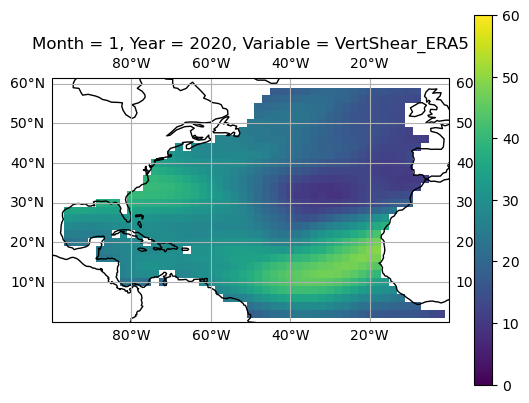

In [13]:
plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_extent([-100, 0, 0, 50])
test_stacked[1].unstack().sel(Month=1,Year=2020).plot(vmin=0,vmax=60)

In [6]:
# # Grab ibtracs data (uncomment this section if you want to recreate genesis (observed) labels, otherwise it is already saved)
# basin_dataset = tracks.TrackDataset(basin='north_atlantic',source='ibtracs',include_btk=True)

# # Create genesis labels from ibtracs data (slowest step)
# vmin=0
# print('Training Dataset')
# train_labels_predropped = create_genesis_grid_labels(month_range,train_years,vmin,basin_dataset)
# print('Testing Dataset')
# test_labels_predropped = create_genesis_grid_labels(month_range,test_years,vmin,basin_dataset)

# train_labels_predropped.unstack().to_dataset(name='Genesis_Grids').to_netcdf("/glade/work/acheung/Initial_RF_Datasets/train_labels_predropped.nc")
# test_labels_predropped.unstack().to_dataset(name='Genesis_Grids').to_netcdf("/glade/work/acheung/Initial_RF_Datasets/test_labels_predropped.nc")
# # --------------------------------------------------------------------------------------------------------

In [6]:
# Read in already created genesis (obs) labels
train_labels_predropped_read = xr.open_dataset("/glade/work/acheung/Initial_RF_Datasets/train_labels_predropped.nc")['Genesis_Grids']
test_labels_predropped_read = xr.open_dataset("/glade/work/acheung/Initial_RF_Datasets/test_labels_predropped.nc")['Genesis_Grids']

# Smooth Training Labels
smoothed_training_labels = temporal_spatial_smoothing(train_labels_predropped_read.astype(float),0.5,1)
smoothed_training_labels_dropped = smoothed_training_labels.stack(z=("Month","Latitude","Longitude","Year")).drop_isel(z=train_NaNlocs).transpose()

# Apply land/ocean mask to training labels
smoothed_training_labels_dropped = smoothed_training_labels_dropped.unstack().where(NAOmask.isnull() == False).stack(z=("Month","Latitude","Longitude","Year"))

# Make training anomaly labels (base climatology off training dataset)
if anomaly == 1:
    trainingmonthlymeans = smoothed_training_labels_dropped.unstack().mean('Year')
    smoothed_training_labels_dropped = (smoothed_training_labels_dropped.unstack() - trainingmonthlymeans).stack(z=("Month","Latitude","Longitude","Year"))

# Normalize Training labels
if normalization == 1:
    smoothed_training_labels_dropped_norm = (smoothed_training_labels_dropped - smoothed_training_labels_dropped.min())/(smoothed_training_labels_dropped.max() - smoothed_training_labels_dropped.min())
elif normalization == 2:
    smoothed_training_labels_dropped_norm = (smoothed_training_labels_dropped - smoothed_training_labels_dropped.mean())/(smoothed_training_labels_dropped.std())
    

#-----------Testing Labels---------------

# Smooth Testing Labels (For verification purposes)
smoothed_testing_labels = temporal_spatial_smoothing(test_labels_predropped_read.astype(float),0.5,1)
smoothed_testing_labels_dropped = smoothed_testing_labels.stack(z=("Month","Latitude","Longitude","Year")).drop_isel(z=test_NaNlocs).transpose()

# Apply land/ocean mask to testing labels
smoothed_testing_labels_dropped = smoothed_testing_labels_dropped.unstack().where(NAOmask.isnull() == False).stack(z=("Month","Latitude","Longitude","Year"))

# Make testing anomaly labels (base climatology off training dataset)
if anomaly == 1: # Make anomaly labels (base climatology off training dataset)
    smoothed_testing_labels_dropped = (smoothed_testing_labels_dropped.unstack() - trainingmonthlymeans).stack(z=("Month","Latitude","Longitude","Year"))

# Normalize Testing labels
if normalization == 1:
    smoothed_testing_labels_dropped_norm = (smoothed_testing_labels_dropped - smoothed_training_labels_dropped.min())/(smoothed_training_labels_dropped.max() - smoothed_training_labels_dropped.min())
elif normalization == 2:
    smoothed_testing_labels_dropped_norm = (smoothed_testing_labels_dropped - smoothed_training_labels_dropped.mean())/(smoothed_training_labels_dropped.std())

# Note that above cuts off smoothed labeled values over land, thus changing the sum (may need to revisit)


# !!! Uncomment Fit Model Cell if want to fit model !!!

In [ ]:
# Fit RF Model
clf = RandomForestRegressor()
clf.fit(train_env_data.dropna(dim='z'), smoothed_training_labels_dropped_norm.dropna(dim='z'))
# Predict
test_ML_Predict = clf.predict(test_env_data.dropna(dim='z'))

In [ ]:
## We need to keep track of the places that NaNs were dropped out places that have real data due to the masking

# Recover dropped NaN Labels (labels)
Testing_mask_nan_locs = np.where(smoothed_testing_labels_dropped_norm.isnull() == True)[0] # All nan locations
Testing_mask_data_locs = np.where(smoothed_testing_labels_dropped_norm.isnull() == False)[0] # All data locations

testing_PD = pd.DataFrame(test_ML_Predict,index=Testing_mask_data_locs,columns=['Prediction'])
testing_nan_PD = pd.DataFrame(np.nan, index=Testing_mask_nan_locs,columns=['Prediction'])
testing_reattachedpd = pd.concat([testing_PD,testing_nan_PD]).sort_index()

# Put reNan'd ML Testing Results into Xarray
testing_reattached_xr = xr.DataArray(testing_reattachedpd['Prediction'],coords = smoothed_testing_labels_dropped_norm.coords).unstack()

# Save ML results to netCDF
if anomaly == 1:
    testing_reattached_xr.to_dataset(name='Testing_Results').to_netcdf("/glade/work/acheung/Initial_RF_Datasets/ml_test_results_with_anomaly.nc")
else:
    testing_reattached_xr.to_dataset(name='Testing_Results').to_netcdf("/glade/work/acheung/Initial_RF_Datasets/ml_test_results_without_anomaly.nc")

# Below this cell involves viewing/quantifying the results of the ML Model

In [ ]:
# Open Saved Dataset
# Change file path to view different saved ML results!
if anomaly == 1:
    test_ML_Predict_XR = xr.open_dataset("/glade/work/acheung/Initial_RF_Datasets/ml_test_results_with_anomaly.nc")['Testing_Results']
else:
    test_ML_Predict_XR = xr.open_dataset("/glade/work/acheung/Initial_RF_Datasets/ml_test_results_without_anomaly.nc")['Testing_Results']


In [ ]:
# Calculate Verification Scores

# 1. RMSE 
y_true = smoothed_testing_labels_dropped_norm.dropna(dim='z')
y_pred = test_ML_Predict_XR.stack(z=("Month","Latitude","Longitude","Year")).dropna(dim='z')
RMSEval = mean_squared_error(y_true, y_pred,squared = False)

#2. Pearson Correlation
pearson_corr = stats.pearsonr(y_true, y_pred)[0] # Default: Two-sided
pearson_p_val = stats.pearsonr(y_true, y_pred)[1]

# Print values
anomalystr = 'With Anomaly Predictors'
withoutanomalystr = 'Without Anomaly Predictors'

# Include test attributes
if normalization == 1:
    normal_method = ' min max normalization'
elif normalization == 2:
    normal_method = ' z-score normalization'

if anomaly == 1:
    score_str = 'RMSE: ' + str(RMSEval) + ', Pearson Corr: ' + str(pearson_corr) + ', P-Value: ' + str(pearson_p_val) + ', ' + anomalystr + normal_method + ' with anomaly inputs'
    print(score_str)
else:
    score_str = 'RMSE: ' + str(RMSEval) + ', Pearson Corr: ' + str(pearson_corr) + ', P-Value: ' + str(pearson_p_val) + ', ' + withoutanomalystr + normal_method + ' with no anomaly inputs'
    print(score_str)

# Write String to text file

#open text file
if anomaly == 1:
    text_file = open("/glade/work/acheung/Initial_RF_Datasets/anomaly_scores.txt", "w")
else:
    text_file = open("/glade/work/acheung/Initial_RF_Datasets/no_anomaly_scores.txt", "w")

text_file.write(score_str)
#close file
text_file.close()

In [ ]:
# Plot data
for test_years_now in test_years:
    mo_view = 8
    yr_view = test_years_now
    plt.figure()
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_global()
    ax.coastlines()
    ax.gridlines(draw_labels=True)
    ax.set_extent([-100, 0, 0, 50])
    (test_ML_Predict_XR.unstack().sel(Month=mo_view,Year=yr_view)).plot(vmin=0)

    scat = test_labels_predropped_read.sel(Month=mo_view,Year=yr_view).stack(new=['Latitude','Longitude'])
    scat_dropped = scat.where(scat>0,drop=True)
    ax.scatter(scat_dropped['Longitude'],scat_dropped['Latitude'],marker='x',color='r')
    if mo_view > 9:
        mostr = str(mo_view)
    else:
        mostr = '0'+str(mo_view)
    timestr = mostr + '_' + str(yr_view)
    
    plt.savefig('/glade/work/acheung/RF_V2_Plots/RF_Reg_plot'+'_'+timestr+'.png',dpi=300)

In [ ]:
# Plot Environmental Data
plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_extent([-100, 0, 0, 50])
test_env_data[:,3].unstack().sel(Month=8,Year=2005).plot()
plt.savefig("Anomaly_Normalized_Plot")